## 1.Drop null values

In [ ]:
import pandas as pd
from collections import Counter
import re
import string

import numpy as np
import tensorflow as tf
from pyvi import ViUtils
from pyvi import ViTokenizer

import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, LayerNormalization, GlobalMaxPooling1D,MaxPooling1D, Conv1D, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential

In [ ]:
df = pd.read_csv('bank dataframe.csv')
df = df[['place_name','review_text','review_rating']]
df

,place_name,review_text,review_rating
0,Vietinbank - PGD Yên Thái,Nv thấy dân lao động không thèm tiếp.ăn nói th...,1
1,Vietinbank - PGD Yên Thái,Ngân hàng quá Tuyệt,5
2,Vietinbank - PGD Yên Thái,Đằng kia,5
3,Vietinbank - PGD Yên Thái,NaN,5
4,Ngân Hàng Công Thương Việt Nam Vietinbank PGD ...,Nhân viên giao dịch tại quầy làm việc không kh...,1
...,...,...,...
3056,Ngân Hàng Tmcp Công Thương Việt Nam - Vietinba...,PGD chỉ có 2 nhân viên giao dịch.Lúc vắng thì ...,1
3057,Ngân Hàng Tmcp Công Thương Việt Nam - Vietinba...,ngân hàng ở đây nói chung là nhân viên cũng tạ...,3
3058,Ngân Hàng Tmcp Công Thương Việt Nam - Vietinba...,"Dịch vụ phong phú, nghiệp vụ nhân viên tô...",4
3059,Ngân Hàng Tmcp Công Thương Việt Nam - Vietinba...,mất thời gian một buổi sáng chờ đợi để lấy tiề...,1


In [ ]:
print('Kiểm tra dữ liệu thiếu: ')
print(df.isnull().sum())

Kiểm tra dữ liệu thiếu: 
place_name         0
review_text      251
review_rating      0
dtype: int64


In [ ]:
df_prepro = df.dropna()

In [ ]:
print(df.shape)
print(df_prepro.shape)

(3061, 3)
(2810, 3)


## 2.Delete emoji

In [ ]:
emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)

def has_emoji_or_symbol(text):
    return bool(emoji_pattern.search(text))

def clear_emoji(text):
  text = re.sub('https?:\/\/\S+','',text)
  text = re.sub('@','',text)
  text = re.sub(emoji_pattern,'',text)
  return text

In [ ]:
type(df_prepro['review_text'].iloc[77])

str

In [ ]:
emoji_amount = []
for i in range(0,len(df_prepro)):
    text = df_prepro['review_text'].iloc[i]
    emoji = has_emoji_or_symbol(text)
    emoji_amount.append(emoji)

print('Thống kê những dòng có icon: ',Counter(emoji_amount))

Thống kê những dòng có icon:  Counter({False: 2726, True: 84})


In [ ]:
df_prepro['none_emoji_review_text'] = df_prepro['review_text'].apply(clear_emoji)

C:\Users\Khanh\AppData\Local\Temp\ipykernel_1856\4205833333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prepro['none_emoji_review_text'] = df_prepro['review_text'].apply(clear_emoji)


In [ ]:
df_prepro['has_emoji_or_symbol'] = df_prepro['review_text'].apply(has_emoji_or_symbol)

# Select only the rows that have emojis or symbols
emoji_rows = df_prepro[df_prepro['has_emoji_or_symbol'] == True]

C:\Users\Khanh\AppData\Local\Temp\ipykernel_1856\3434254181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prepro['has_emoji_or_symbol'] = df_prepro['review_text'].apply(has_emoji_or_symbol)


In [ ]:
emoji_rows[['review_text','none_emoji_review_text']]

,review_text,none_emoji_review_text
94,Vào đây không thiếu tiền đâu nha các bạn. Mấy ...,Vào đây không thiếu tiền đâu nha các bạn. Mấy ...
99,"Rất tệ, giao dịch viên nói chuyện qua điện tho...","Rất tệ, giao dịch viên nói chuyện qua điện tho..."
119,Chị tư vấn viên quầy số 6 hồi chiều giúp em mở...,Chị tư vấn viên quầy số 6 hồi chiều giúp em mở...
182,"Mình đăng kí dịch vụ mở thẻ visa, được chị Pha...","Mình đăng kí dịch vụ mở thẻ visa, được chị Pha..."
223,Thái độ phục vụ tệ. Bảo vệ ngồi đông. Nhưng th...,Thái độ phục vụ tệ. Bảo vệ ngồi đông. Nhưng th...
...,...,...
2778,Rút tiền không ra tiền mà thẻ bị trừ tiền đề n...,Rút tiền không ra tiền mà thẻ bị trừ tiền đề n...
2876,Cũng khá là ok 👍,Cũng khá là ok
2903,Vào đây không thiếu tiền đâu nha các bạn. Mấy ...,Vào đây không thiếu tiền đâu nha các bạn. Mấy ...
2927,Chăm sóc sau bán hàng tốt 😍😍😍,Chăm sóc sau bán hàng tốt


## 3.Remove punctuation, lowercase, tokenize data

In [ ]:
df_prepro['review_rating'] = np.where(df_prepro['review_rating']<=2, 'Tiêu cực',np.where(df_prepro['review_rating']>3,'Tích cực','Trung lập'))

C:\Users\Khanh\AppData\Local\Temp\ipykernel_1856\3613136909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prepro['review_rating'] = np.where(df_prepro['review_rating']<=2, 'Tiêu cực',np.where(df_prepro['review_rating']>3,'Tích cực','Trung lập'))


In [ ]:
df_prepro.head(5)

,place_name,review_text,review_rating,none_emoji_review_text,has_emoji_or_symbol
0,Vietinbank - PGD Yên Thái,Nv thấy dân lao động không thèm tiếp.ăn nói th...,Tiêu cực,Nv thấy dân lao động không thèm tiếp.ăn nói th...,False
1,Vietinbank - PGD Yên Thái,Ngân hàng quá Tuyệt,Tích cực,Ngân hàng quá Tuyệt,False
2,Vietinbank - PGD Yên Thái,Đằng kia,Tích cực,Đằng kia,False
4,Ngân Hàng Công Thương Việt Nam Vietinbank PGD ...,Nhân viên giao dịch tại quầy làm việc không kh...,Tiêu cực,Nhân viên giao dịch tại quầy làm việc không kh...,False
5,Ngân Hàng Công Thương Việt Nam Vietinbank PGD ...,"Nhân viên làm chậm, và vừa làm vừa buôn chuyện...",Tiêu cực,"Nhân viên làm chậm, và vừa làm vừa buôn chuyện...",False


In [ ]:
df_prepro['review_text'][60]

'Phục vụ tốt'

In [ ]:
df1 = df_prepro[['none_emoji_review_text','review_rating']]
df1['review_rating'].value_counts()

Tích cực     1330
Tiêu cực     1321
Trung lập     159
Name: review_rating, dtype: int64

In [ ]:
df1['none_emoji_review_text'][1]

'Ngân hàng quá Tuyệt'

In [ ]:
input_data = df1['none_emoji_review_text'].to_list()
input_label = df1['review_rating'].to_list()


input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
  input_text_pre = tf.keras.preprocessing.text.text_to_word_sequence(dt)
  input_text_pre = " ".join(input_text_pre)
  input_text_pre_no_accent = ViUtils.remove_accents(input_text_pre).decode('utf-8')
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
  input_pre.append(input_text_pre_accent)
  input_pre.append(input_text_pre_no_accent)
  label_with_accent.append(input_label[idx])
  label_with_accent.append(input_label[idx])

In [ ]:
len(input_pre)

5620

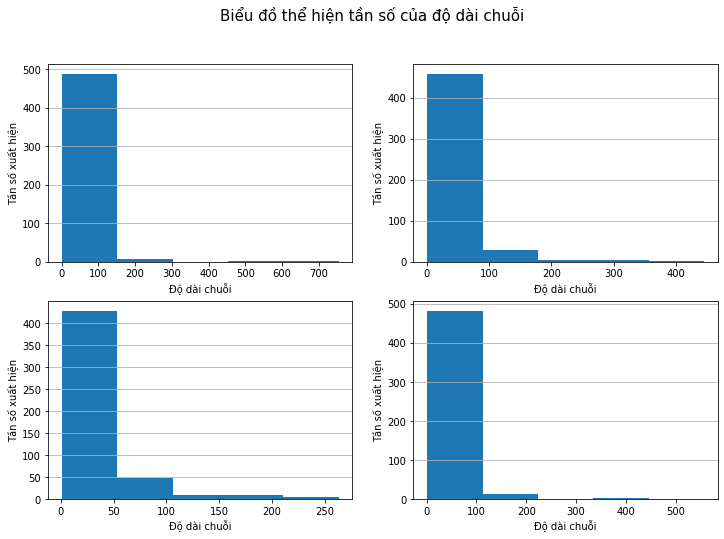

In [ ]:
fig= plt.figure(figsize = ([12, 8]))
fig. suptitle("Biểu đồ thể hiện tần số của độ dài chuỗi", fontsize=15)

plt.subplot(2, 2, 1)
pd.Series([len(i.split()) for i in input_pre[0:500]]).hist(bins = 5)
plt.xlabel('Độ dài chuỗi')
plt.ylabel('Tần số xuất hiện')
plt.grid(axis = 'x')
plt.subplot(2, 2, 2)
pd.Series([len(i.split()) for i in input_pre[500:1000]]).hist(bins = 5)
plt.xlabel('Độ dài chuỗi')
plt.ylabel('Tần số xuất hiện')
plt.grid(axis = 'x')
plt.subplot(2, 2, 3)
pd.Series([len(i.split()) for i in input_pre[1000:1500]]).hist(bins = 5)
plt.xlabel('Độ dài chuỗi')
plt.ylabel('Tần số xuất hiện')
plt.grid(axis = 'x')
plt.subplot(2, 2, 4)
pd.Series([len(i.split()) for i in input_pre[1500:2000]]).hist(bins = 5)
plt.xlabel('Độ dài chuỗi')
plt.ylabel('Tần số xuất hiện')
plt.grid(axis = 'x')

plt.show()

In [ ]:
seq = [len(i.split()) for i in input_pre]
maxlen = int(np.percentile(seq, 95))
maxlen

97

## 4.Vectorize & split data

In [ ]:
#Vector hóa nhãn
label_dict = {'Tiêu cực': 0,'Trung lập': 1,'Tích cực':2}
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx,num_classes=3,dtype='float32')

# Vector hóa dữ liệu
tokenize_data = Tokenizer(oov_token='<OOV>',filters='',split=' ')
tokenize_data.fit_on_texts(input_pre)
pickle.dump(tokenize_data, open("tokenize_data.pkl","wb"))

tokenize_data_text = tokenize_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenize_data_text,padding='post',maxlen=108)
vec_data
#pickle.dump(tokenize_data, open("tokenize_data.pkl_2","wb"))

array([[ 203,  190, 1368, ...,    0,    0,    0],
       [ 203,  130,  220, ...,    0,    0,    0],
       [  16,  105, 1369, ...,    0,    0,    0],
       ...,
       [  79,  169,  195, ...,    0,    0,    0],
       [   8,  878,  312, ...,    0,    0,    0],
       [   4,    5,  773, ...,    0,    0,    0]])

In [ ]:
type(tokenize_data)

keras.preprocessing.text.Tokenizer

In [ ]:
input_pre[230]

'giao_dịch nhanh gọn nhân_viên dễ_thương'

In [ ]:
tokenize_data = Tokenizer(oov_token='<OOV>',filters='',split=' ')
tokenize_data.fit_on_texts(input_pre)

tokenize_data_text = tokenize_data.texts_to_sequences(input_pre)
vec_data1 = pad_sequences(tokenize_data_text,maxlen=108)
vec_data1

array([[   0,    0,    0, ...,  440,  477, 1236],
       [   0,    0,    0, ...,  440,  477,  307],
       [   0,    0,    0, ...,   16,  105, 1369],
       ...,
       [   0,    0,    0, ...,   21,  145,  613],
       [   0,    0,    0, ...,  203,  105,  128],
       [   0,    0,    0, ...,  203,   35,   81]])

In [ ]:
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx,num_classes=3,dtype='float32')
label_tf[2]

array([0., 0., 1.], dtype=float32)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(vec_data,label_tf,test_size = 0.2,random_state=42)
df_train, df_test, df_y_train, df_y_test = train_test_split(df1['none_emoji_review_text'],df1['review_rating'],test_size = 0.1,random_state=42)

In [ ]:
df1

,none_emoji_review_text,review_rating
0,Nv thấy dân lao động không thèm tiếp.ăn nói th...,Tiêu cực
1,Ngân hàng quá Tuyệt,Tích cực
2,Đằng kia,Tích cực
4,Nhân viên giao dịch tại quầy làm việc không kh...,Tiêu cực
5,"Nhân viên làm chậm, và vừa làm vừa buôn chuyện...",Tiêu cực
...,...,...
3056,PGD chỉ có 2 nhân viên giao dịch.Lúc vắng thì ...,Tiêu cực
3057,ngân hàng ở đây nói chung là nhân viên cũng tạ...,Trung lập
3058,"Dịch vụ phong phú, nghiệp vụ nhân viên tô...",Tích cực
3059,mất thời gian một buổi sáng chờ đợi để lấy tiề...,Tiêu cực


In [ ]:
data_vocab_size = len(tokenize_data.word_index)+1
print(data_vocab_size)

6495
